In [77]:
# @title Import libraries
import wget
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import warnings
import os
import numpy as np
from scipy.stats import norm
import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

path = os.getcwd()
import torch
import torch.nn as nn
tt = torch.tensor
from math import log
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from pandas import json_normalize
from scipy.spatial import distance

import selfies as sf
import gpax
import atomai as aoi

import jax.numpy as jnp
from utils.helper_functions import *
# gpax.utils.enable_x64()

In [78]:
git_link = "https://github.com/aghosh92/DKLActiveLearnMol/blob/main/datasets/dataset0_5k.csv?raw=true"
df = pd.read_csv(git_link, index_col=0)

selfies_dataset = []
error_smiles = []

# Assuming 'smiles' is the column in df containing SMILES strings
# Replace 'smiles' with the actual column name if it's different
for i, row in df.iterrows():
    try:
        local_sf = sf.encoder(row['smiles'])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(row['smiles'])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

length_list = []
for s in selfies_dataset:
  length = sf.len_selfies(s)
  length_list.append(length)
length_list.sort()
pad_to_len = length_list[-1]

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)


#Different targets
target_properties = ["ringct","mole_logp","mol_wt","dipole_moment"]

targets = {prop:df[f"{prop}"].values for prop in target_properties}

targets1 = df['ringct'].values
targets2 = df['mole_logp'].values
targets3 = df['mol_wt'].values
targets4 = df['dipole_moment'].values

X1 = np.copy(X)
X1 = X1[:1000]

(5000, 567)


In [79]:
!docker run --name vidkl --rm -p7687:7687 -p7474:7474 -d -v $HOME/neo4j/data:/data -v $HOME/neo4j/logs:/logs -v $HOME/neo4j/import:/var/lib/neo4j/import -v $HOME/neo4j/plugins:/plugins --env NEO4J_AUTH=neo4j/test1234 neo4j:latest

docker: Error response from daemon: Conflict. The container name "/vidkl" is already in use by container "4f5adaaa68dbe5949743ea4285ebd731f2b60c077dd2784d4ac788569bd5e43b". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


CMF Initialization

In [80]:
!cmf init local --path /lustre/saranath/Techcon24/viDKL/ \
--git-remote-url https://github.com/g3saranath/DKLActiveLearnMol \
--cmf-server-url http://0.0.0.0:8080 \
--neo4j-user neo4j --neo4j-password test1234 --neo4j-uri bolt://localhost:7687

git_dir /lustre/saranath/Techcon24/viDKL/.git
Starting cmf init.
Setting 'local-storage' as a default remote.
cmf init complete.


In [82]:
from cmflib import cmf
from ml_metadata.proto import metadata_store_pb2 as mlpb 
cmf.metadata_pull("VIDKL",f"vidkl")
cmf.artifact_pull("VIDKL",f"./vidkl")

SUCCESS: vidkl is successfully pulled.
object 8e/5128cbf6dd06be47afd85e4b723006 downloaded at ./DKL/train_data.npy.
object fd/36b68205aed58e2696ea2e206714de downloaded at ./DKL/target_data.npy.
object 0b/624c4007ca3411e96cf4f6b1585529 downloaded at ./DKL/dkl1_kernel_params.npy.
object dd/2c12df7a11b3b5cd961c99feaca651 downloaded at ./DKL/dkl1_nn_params_dict.npy.
object 2b/df39e11f59ec59048cbe12f3784e66 downloaded at ./DKL/embedding.npy.
object 78/9eaa98fc9d368b476254070a502512 downloaded at ./DKL/prediccted_std.npy.
object af/1db45ff6df4c69d36894c9b6661ba3 downloaded at ./DKL/predicted_mean.npy.
object 53/35e226949dfa7eb05451ee6f888231 downloaded at ./DKL/predicted_unc.npy.
object 59/db945f9719c1b9a7cce72dcc944754 downloaded at ./DKL/active_learning_nn_model_50_UCB.npy.
object 71/5df82047301b9d8238a46ee539f511 downloaded at ./DKL/active_learning_kernel_model_50_UCB.npy.
object 43/784920af355b8fb37223bdbd36b006 downloaded at ./DKL/active_train_50_UCB.npy.
object de/bd013cee3cb7c1843b895

'Done'

CMF Object Creation from the pulled mlmd --> pipeline

In [83]:
from cmflib.cmf import Cmf 

graph = True 
metalogger = Cmf(
    filename="vidkl",
    pipeline_name="VIDKL_AL",
    graph = graph
)

*** Note: CMF will check out a new branch in git to commit the metadata files ***
*** The checked out branch is vidkl. ***


Querying the file to identify the appropriate artifacts where the loss starts to increase such that the continous training can be performed

In [221]:
from cmflib.cmf_merger import parse_json_to_mlmd
import pandas as pd
import dvc

from cmflib import cmfquery

from IPython.display import display, HTML
import json 
import ast
from datetime import datetime
query = cmfquery.CmfQuery()
query = cmfquery.CmfQuery(f"./vidkl")

stages = query.get_pipeline_stages("vidkl")
display(stages)

['vidkl/Training', 'vidkl/Predict', 'vidkl/Active Learning']

In [222]:

executions = query.get_all_executions_in_stage(stages[2])
print(len(executions))

display(executions)

print(f"Displaying the artifacts for execution with id {executions.iloc[0]['id']} belonging to {stages[2]}")
artifacts = query.get_all_artifacts_for_execution(executions.iloc[0]["id"])
display(artifacts)

df = executions
len(df)

30


,Context_ID,Context_Type,Execution,Execution_type_name,Execution_uuid,Git_End_Commit,Git_Repo,Git_Start_Commit,Pipeline_Type,Pipeline_id,...,custom_properties_Pearson_Coeff,custom_properties_Target_Property,custom_properties_Target_property,custom_properties_Test_Loss,custom_properties_Train_size,custom_properties_Training_loss,custom_properties_Unmeasured_size,custom_properties_indices_selected,id,name
0,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,3b43db80-0228-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.066403,enthalpy,NaN,41589.399608,NaN,106.255239,NaN,NaN,139,
1,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,f3fab852-0227-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.081313,enthalpy,NaN,45930.745887,NaN,96.858554,NaN,NaN,138,
2,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,adcaaa22-0227-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.093705,enthalpy,NaN,43249.639926,NaN,91.547662,NaN,NaN,137,
3,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,66ab0e70-0227-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.067644,enthalpy,NaN,45027.529961,NaN,91.387110,NaN,NaN,136,
4,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,10eaeb36-0227-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.065271,enthalpy,NaN,42440.655193,NaN,92.341686,NaN,NaN,135,
5,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,ce3b67d4-0226-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.089700,enthalpy,NaN,39088.967888,NaN,95.642103,NaN,NaN,134,
6,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,8c1c4274-0226-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.078034,enthalpy,NaN,42523.559561,NaN,97.705971,NaN,NaN,133,
7,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,4afe2d70-0226-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.092302,enthalpy,NaN,41900.099340,NaN,97.674667,NaN,NaN,132,
8,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,0bf8b50a-0226-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.062348,enthalpy,NaN,42390.605979,NaN,95.409486,NaN,NaN,131,
9,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,ce412b0c-0225-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.092013,enthalpy,NaN,39188.891166,NaN,113.292829,NaN,NaN,130,


Displaying the artifacts for execution with id 139 belonging to vidkl/Active Learning


,Commit,create_time_since_epoch,custom_properties_original_create_time_since_epoch,event,git_repo,id,last_update_time_since_epoch,model_framework,model_name,model_type,name,type,uri,url
0,348106f2060f89b19d7472599f4aa365,1713946962512,NaN,OUTPUT,NaN,182,1713955741621,mlp,nn_params,Default,DKL/active_learning_nn_model_29_UCB.npy:348106...,Model,348106f2060f89b19d7472599f4aa365,VIDKL:/lustre/saranath/Techcon24/viDKL//34/810...
1,5a2c9ac7ed59d284a60fd5d4650bf597,1713946970400,NaN,INPUT,NaN,183,1713955781793,gpax,kernel_params,Default,DKL/active_learning_kernel_model_29_UCB.npy:5a...,Model,5a2c9ac7ed59d284a60fd5d4650bf597,VIDKL:/lustre/saranath/Techcon24/viDKL//5a/2c9...
2,9cc9e40f83f5128554cacc9bbdae77ee,1713946978348,1.713947e+12,OUTPUT,https://github.com/g3saranath/DKLActiveLearnMo...,184,1713955794514,NaN,NaN,NaN,DKL/active_train_29_UCB.npy:9cc9e40f83f5128554...,Dataset,9cc9e40f83f5128554cacc9bbdae77ee,VIDKL:/lustre/saranath/Techcon24/viDKL//9c/c9e...


30

Plotting Loss Transitions - From the logged cmf artifacts

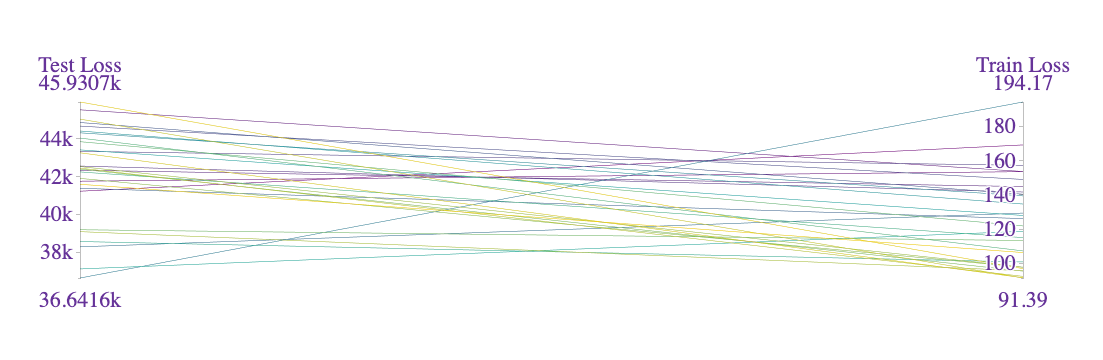

In [223]:
import plotly.graph_objects as go
import pandas as pd

# Sample data (replace this with your actual data)
data = {
    'id': df["id"],
    'custom_properties_Train_Loss': df["custom_properties_Training_loss"],
    'custom_properties_Test_Loss': df["custom_properties_Test_Loss"]
}
df = pd.DataFrame(data)

# Create parallel coordinates plot
fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df['id'],
        colorscale=[[0, 'purple'], [0.5, 'lightseagreen'], [1, 'gold']]
    ),
    dimensions=list([
        dict(
            range=[min(df["custom_properties_Test_Loss"]), max(df["custom_properties_Test_Loss"])],
            label='Test Loss',
            values=df['custom_properties_Test_Loss']
        ),
        
        dict(
            range=[min(df["custom_properties_Train_Loss"]), max(df["custom_properties_Train_Loss"])],
            label='Train Loss',
            values=df['custom_properties_Train_Loss']
        ),
    ])
))

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(
        family="Droid Sans",
        size=26,
        color="RebeccaPurple"
    )
)

fig.show()


Identifying where the loss starts to increase by a `Threshold` value to perform continous training. Please change the `Threshold`, based on observation keeping the value as 45 for now.    

In [224]:
import pandas as pd
threshold = 5
def find_loss_increase_point(df, column_name,threshold):
    prev_loss = None
    for index, loss_value in zip(df[column_name].index, df[column_name].values):
        if prev_loss is not None and loss_value - prev_loss > threshold:
            return df["id"].iloc[index]
        prev_loss = loss_value
    return None

# Example usage:
# Assuming you have a DataFrame named 'df' with a column containing loss values named 'loss'
# Replace 'df' and 'loss' with your actual DataFrame and column name
index_of_loss_increase = find_loss_increase_point(df, 'custom_properties_Train_Loss',threshold)

if index_of_loss_increase is not None:
    print(f"The loss starts to increase at index: {index_of_loss_increase}")
else:
    print("No increase in loss found.")


The loss starts to increase at index: 130


In [225]:
executions

,Context_ID,Context_Type,Execution,Execution_type_name,Execution_uuid,Git_End_Commit,Git_Repo,Git_Start_Commit,Pipeline_Type,Pipeline_id,...,custom_properties_Pearson_Coeff,custom_properties_Target_Property,custom_properties_Target_property,custom_properties_Test_Loss,custom_properties_Train_size,custom_properties_Training_loss,custom_properties_Unmeasured_size,custom_properties_indices_selected,id,name
0,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,3b43db80-0228-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.066403,enthalpy,NaN,41589.399608,NaN,106.255239,NaN,NaN,139,
1,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,f3fab852-0227-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.081313,enthalpy,NaN,45930.745887,NaN,96.858554,NaN,NaN,138,
2,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,adcaaa22-0227-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.093705,enthalpy,NaN,43249.639926,NaN,91.547662,NaN,NaN,137,
3,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,66ab0e70-0227-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.067644,enthalpy,NaN,45027.529961,NaN,91.387110,NaN,NaN,136,
4,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,10eaeb36-0227-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.065271,enthalpy,NaN,42440.655193,NaN,92.341686,NaN,NaN,135,
5,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,ce3b67d4-0226-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.089700,enthalpy,NaN,39088.967888,NaN,95.642103,NaN,NaN,134,
6,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,8c1c4274-0226-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.078034,enthalpy,NaN,42523.559561,NaN,97.705971,NaN,NaN,133,
7,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,4afe2d70-0226-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.092302,enthalpy,NaN,41900.099340,NaN,97.674667,NaN,NaN,132,
8,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,0bf8b50a-0226-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.062348,enthalpy,NaN,42390.605979,NaN,95.409486,NaN,NaN,131,
9,11,vidkl/Active Learning,['/lustre/saranath/miniconda3/envs/vaedkl/lib/...,vidkl/Active Learning,ce412b0c-0225-11ef-a355-b47af137252e,,https://github.com/g3saranath/DKLActiveLearnMo...,HEAD,vidkl,8,...,-0.092013,enthalpy,NaN,39188.891166,NaN,113.292829,NaN,NaN,130,


In [226]:
index = executions[executions["id"]==index_of_loss_increase]["id"].index[0]
print(index_of_loss_increase)
print("In Index:",index)
query.get_all_artifacts_for_execution(index_of_loss_increase)

130
In Index: 9


,Commit,create_time_since_epoch,custom_properties_Commit,custom_properties_Name,custom_properties_original_create_time_since_epoch,event,git_repo,id,last_update_time_since_epoch,model_framework,model_name,model_type,name,type,uri,url
0,b81018ea9e5582727877dcf7580abde8,1713946319651,NaN,NaN,NaN,OUTPUT,NaN,128,1713954697556,mlp,nn_params,Default,DKL/active_learning_nn_model_20_UCB.npy:b81018...,Model,b81018ea9e5582727877dcf7580abde8,VIDKL:/lustre/saranath/Techcon24/viDKL//b8/101...
1,a8cc75e895b9e66d9be50eb736537ff0,1713946325454,NaN,NaN,NaN,INPUT,NaN,129,1713954708134,gpax,kernel_params,Default,DKL/active_learning_kernel_model_20_UCB.npy:a8...,Model,a8cc75e895b9e66d9be50eb736537ff0,VIDKL:/lustre/saranath/Techcon24/viDKL//a8/cc7...
2,d540fa1b4b9e50de3230d3825529cee0,1713946331550,NaN,NaN,1.713946e+12,OUTPUT,https://github.com/g3saranath/DKLActiveLearnMo...,130,1713954718621,NaN,NaN,NaN,DKL/active_train_20_UCB.npy:d540fa1b4b9e50de32...,Dataset,d540fa1b4b9e50de3230d3825529cee0,VIDKL:/lustre/saranath/Techcon24/viDKL//d5/40f...
3,1f73f2593b10edbf3c9684a48196f0a9,1713946337666,NaN,NaN,1.713946e+12,OUTPUT,https://github.com/g3saranath/DKLActiveLearnMo...,131,1713954729385,NaN,NaN,NaN,DKL/active_trgt_20_UCB.npy:1f73f2593b10edbf3c9...,Dataset,1f73f2593b10edbf3c9684a48196f0a9,VIDKL:/lustre/saranath/Techcon24/viDKL//1f/73f...
4,77a0ea946558bd8d21692486a84b35e5,1713946343850,NaN,NaN,1.713946e+12,OUTPUT,https://github.com/g3saranath/DKLActiveLearnMo...,132,1713954740140,NaN,NaN,NaN,DKL/embed_traj_20_UCB.npy:77a0ea946558bd8d2169...,Dataset,77a0ea946558bd8d21692486a84b35e5,VIDKL:/lustre/saranath/Techcon24/viDKL//77/a0e...
5,NaN,1713954748606,9e1406392bf21010467bcf8fef4c31b2,DKL/obj_funct19_val,NaN,OUTPUT,NaN,336,1713954748606,NaN,NaN,NaN,DKL/obj_funct19_val:9e1406392bf21010467bcf8fef...,Step_Metrics,9e1406392bf21010467bcf8fef4c31b2,NaN
6,b52d5785b360b0aa4af7b529878b081f,1713946245025,NaN,NaN,1.713946e+12,INPUT,https://github.com/g3saranath/DKLActiveLearnMo...,124,1713954613826,NaN,NaN,NaN,DKL/active_train_19_UCB.npy:b52d5785b360b0aa4a...,Dataset,b52d5785b360b0aa4af7b529878b081f,VIDKL:/lustre/saranath/Techcon24/viDKL//b5/2d5...
7,7076e131114674dca857f3d645243891,1713946278501,NaN,NaN,1.713946e+12,INPUT,https://github.com/g3saranath/DKLActiveLearnMo...,125,1713954624321,NaN,NaN,NaN,DKL/active_trgt_19_UCB.npy:7076e131114674dca85...,Dataset,7076e131114674dca857f3d645243891,VIDKL:/lustre/saranath/Techcon24/viDKL//70/76e...
8,96d3f95e6c233cb8702d0319395bd8e9,1713946233379,NaN,NaN,NaN,INPUT,NaN,122,1713954592767,mlp,nn_params,Default,DKL/active_learning_nn_model_19_UCB.npy:96d3f9...,Model,96d3f95e6c233cb8702d0319395bd8e9,VIDKL:/lustre/saranath/Techcon24/viDKL//96/d3f...
9,ae327a500816a034ed9781974622e14e,1713946239145,NaN,NaN,NaN,INPUT,NaN,123,1713954603251,gpax,kernel_params,Default,DKL/active_learning_kernel_model_19_UCB.npy:ae...,Model,ae327a500816a034ed9781974622e14e,VIDKL:/lustre/saranath/Techcon24/viDKL//ae/327...


,id,custom_properties_Train_Loss,custom_properties_Test_Loss
0,111,169.103424,41222.170855
1,112,153.492698,41750.135714
2,113,153.572007,45518.706952
3,114,144.770976,42331.891109
4,115,141.607558,42550.460972
5,116,157.179375,43325.913471
6,117,148.934891,44658.171771
7,118,140.315646,44847.905730
8,119,126.067596,41377.708820


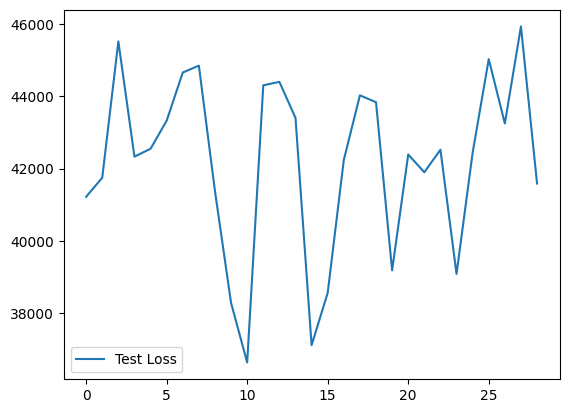

In [227]:
df.sort_values(by='id',inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
plt.plot(df["custom_properties_Test_Loss"],label="Test Loss")
plt.legend()
df[:index]

Collecting the Model from where the loss starts to increase

In [234]:
index = executions[executions['id']==index_of_loss_increase].index[0]
print("index :",index)
print(f"Displaying the artifacts for execution with id {executions.iloc[index]['id']} belonging to {stages[2]}")
artifacts = query.get_all_artifacts_for_execution(executions.iloc[index]["id"])
display(artifacts)
artifact_name = []
for ind, art in artifacts.iterrows():
    if art["event"] == "INPUT" and art["type"]=="Model":
        display(art["name"])
        artifact_name.append(str(art["name"]).split(":")[0])
artifact_name

index : 9
Displaying the artifacts for execution with id 130 belonging to vidkl/Active Learning


,Commit,create_time_since_epoch,custom_properties_Commit,custom_properties_Name,custom_properties_original_create_time_since_epoch,event,git_repo,id,last_update_time_since_epoch,model_framework,model_name,model_type,name,type,uri,url
0,b81018ea9e5582727877dcf7580abde8,1713946319651,NaN,NaN,NaN,OUTPUT,NaN,128,1713954697556,mlp,nn_params,Default,DKL/active_learning_nn_model_20_UCB.npy:b81018...,Model,b81018ea9e5582727877dcf7580abde8,VIDKL:/lustre/saranath/Techcon24/viDKL//b8/101...
1,a8cc75e895b9e66d9be50eb736537ff0,1713946325454,NaN,NaN,NaN,INPUT,NaN,129,1713954708134,gpax,kernel_params,Default,DKL/active_learning_kernel_model_20_UCB.npy:a8...,Model,a8cc75e895b9e66d9be50eb736537ff0,VIDKL:/lustre/saranath/Techcon24/viDKL//a8/cc7...
2,d540fa1b4b9e50de3230d3825529cee0,1713946331550,NaN,NaN,1.713946e+12,OUTPUT,https://github.com/g3saranath/DKLActiveLearnMo...,130,1713954718621,NaN,NaN,NaN,DKL/active_train_20_UCB.npy:d540fa1b4b9e50de32...,Dataset,d540fa1b4b9e50de3230d3825529cee0,VIDKL:/lustre/saranath/Techcon24/viDKL//d5/40f...
3,1f73f2593b10edbf3c9684a48196f0a9,1713946337666,NaN,NaN,1.713946e+12,OUTPUT,https://github.com/g3saranath/DKLActiveLearnMo...,131,1713954729385,NaN,NaN,NaN,DKL/active_trgt_20_UCB.npy:1f73f2593b10edbf3c9...,Dataset,1f73f2593b10edbf3c9684a48196f0a9,VIDKL:/lustre/saranath/Techcon24/viDKL//1f/73f...
4,77a0ea946558bd8d21692486a84b35e5,1713946343850,NaN,NaN,1.713946e+12,OUTPUT,https://github.com/g3saranath/DKLActiveLearnMo...,132,1713954740140,NaN,NaN,NaN,DKL/embed_traj_20_UCB.npy:77a0ea946558bd8d2169...,Dataset,77a0ea946558bd8d21692486a84b35e5,VIDKL:/lustre/saranath/Techcon24/viDKL//77/a0e...
5,NaN,1713954748606,9e1406392bf21010467bcf8fef4c31b2,DKL/obj_funct19_val,NaN,OUTPUT,NaN,336,1713954748606,NaN,NaN,NaN,DKL/obj_funct19_val:9e1406392bf21010467bcf8fef...,Step_Metrics,9e1406392bf21010467bcf8fef4c31b2,NaN
6,b52d5785b360b0aa4af7b529878b081f,1713946245025,NaN,NaN,1.713946e+12,INPUT,https://github.com/g3saranath/DKLActiveLearnMo...,124,1713954613826,NaN,NaN,NaN,DKL/active_train_19_UCB.npy:b52d5785b360b0aa4a...,Dataset,b52d5785b360b0aa4af7b529878b081f,VIDKL:/lustre/saranath/Techcon24/viDKL//b5/2d5...
7,7076e131114674dca857f3d645243891,1713946278501,NaN,NaN,1.713946e+12,INPUT,https://github.com/g3saranath/DKLActiveLearnMo...,125,1713954624321,NaN,NaN,NaN,DKL/active_trgt_19_UCB.npy:7076e131114674dca85...,Dataset,7076e131114674dca857f3d645243891,VIDKL:/lustre/saranath/Techcon24/viDKL//70/76e...
8,96d3f95e6c233cb8702d0319395bd8e9,1713946233379,NaN,NaN,NaN,INPUT,NaN,122,1713954592767,mlp,nn_params,Default,DKL/active_learning_nn_model_19_UCB.npy:96d3f9...,Model,96d3f95e6c233cb8702d0319395bd8e9,VIDKL:/lustre/saranath/Techcon24/viDKL//96/d3f...
9,ae327a500816a034ed9781974622e14e,1713946239145,NaN,NaN,NaN,INPUT,NaN,123,1713954603251,gpax,kernel_params,Default,DKL/active_learning_kernel_model_19_UCB.npy:ae...,Model,ae327a500816a034ed9781974622e14e,VIDKL:/lustre/saranath/Techcon24/viDKL//ae/327...


'DKL/active_learning_kernel_model_20_UCB.npy:a8cc75e895b9e66d9be50eb736537ff0:23'

'DKL/active_learning_nn_model_19_UCB.npy:96d3f95e6c233cb8702d0319395bd8e9:22'

'DKL/active_learning_kernel_model_19_UCB.npy:ae327a500816a034ed9781974622e14e:22'

['DKL/active_learning_kernel_model_20_UCB.npy',
 'DKL/active_learning_nn_model_19_UCB.npy',
 'DKL/active_learning_kernel_model_19_UCB.npy']

At 13th Exploration, the Test loss has started to increase. Now let us load the model from the pulled artifacts to perform Continous Training

In [235]:
import pickle
import pandas as pd
import numpy


def load_params(filename):
    with open(filename,'rb') as f:
        val = jnp.load(filename,allow_pickle=True)
    f.close()
    return val.item()

nn_read = load_params(artifact_name[1])
kernel_read = load_params(artifact_name[2])



In [236]:
exploration_point = int(artifact_name[1].split(".")[0].split("_")[-2])
exploration_point

19

Initialized Model from the obtained artifact from the Previous step

In [237]:
rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()

dkl_1 = gpax.viDKL(s2*s3, 2, 'RBF')

dkl_1.nn_params = nn_read 
dkl_1.kernel_params = kernel_read

In [238]:
git_link = "https://github.com/aghosh92/DKLActiveLearnMol/blob/main/datasets/dataset0_5k.csv?raw=true"
df_qm = pd.read_csv(git_link, index_col=0)

In [239]:
selfies_dataset = []
error_smiles = []

# Assuming 'smiles' is the column in df containing SMILES strings
# Replace 'smiles' with the actual column name if it's different
for i, row in df_qm.iterrows():
    try:
        local_sf = sf.encoder(row['smiles'])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(row['smiles'])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

length_list = []
for s in selfies_dataset:
  length = sf.len_selfies(s)
  length_list.append(length)
length_list.sort()
pad_to_len = length_list[-1]

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

(5000, 567)


Initializing losses until index for continous training (Train and Test Loss)

In [240]:
train_loss = df[:index]["custom_properties_Train_Loss"]
test_loss = df[:index]["custom_properties_Test_Loss"]

## Training

In [241]:
X1 = np.copy(X)
X1 = X1[:1000]
## Target: ringct
targets1 = targets1[:1000]

#Train the DKL model
rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()
dkl_1 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)

batch_size_reconstruct = 250
embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)
pred_std1 = jnp.sqrt(pred_var1)


Inferred GP kernel parameters
k_length         [1.4532 1.8223]
k_scale          5.6738997
noise            1.5716


In [242]:
#Different targets
target_properties = ["ringct","mole_logp","mol_wt","dipole_moment"]

targets = {prop:df_qm[f"{prop}"].values for prop in target_properties}

targets1 = df_qm['ringct'].values
targets2 = df_qm['mole_logp'].values
targets3 = df_qm['mol_wt'].values
targets4 = df_qm['dipole_moment'].values

X1 = np.copy(X)
X1 = X1[:1000]

targets1 = - df_qm['enthalpy'].values
targets1 = targets1[:1000]
target_property = "enthalpy"
acquisition_function = "Entropy"

np.save("DKL/X_al.npy",np.array(X1))
np.save("DKL/trgt_enthalpy_al.npy",np.array(targets1))

In [243]:
#Active learning setup parameters
init_num = 50
exp_step = 20
batch_size_learn = 50 #make it 100 if start with 100 seed
batch_size_reconstruct = 250

np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = init_num, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(X))
indices_train_1 = indices_total_1[idx1]

y1_train = targets1[idx1]
y1_unmeasured = np.delete(targets1, idx1, axis=0)

indices_unmeasured_1 = np.delete(indices_total_1, idx1)

np.save("DKL/active_train_0.npy",np.array(X1_train))
np.save("DKL/X_unmeasured_al.npy",np.array(X1_unmeasured))

np.save("DKL/indices_train_al.npy",np.array(indices_train_1))
np.save("DKL/indices_unmeasured_al.npy",np.array(indices_unmeasured_1))

np.save("DKL/active_trgt_0.npy",np.array(y1_train))

CMF Logging of the Training Stage

In [129]:
context_stage = metalogger.create_context(pipeline_stage="Active Learning",
                                          custom_properties={"Number_of_training_points":init_num,
                                                             "Target_property":target_property,
                                                             "Acquisition_function":acquisition_function,
                                                            "Total_Data_size":X1.shape,
                                                            "Exploration_Steps":exp_step,
                                                            "Batch_size":batch_size_learn,
                                                            "Batch_size_reconstruct":batch_size_reconstruct})
execution_stage = metalogger.create_execution(execution_type="Active Learning",
                                        custom_properties={"Number_of_training_points":init_num,
                                                           "Exploration_Steps":exp_step,
                                                           "Train_size":(X1_train.shape),
                                                           "Unmeasured_size":(X1_unmeasured.shape),
                                                           "indices_selected":idx1,
                                                          "Target_property":target_property,
                                                          "Acquisition_function":acquisition_function})

# Input data selected for AL
_ = metalogger.log_dataset("DKL/X_al.npy","input")
_ = metalogger.log_dataset("DKL/trgt_enthalpy_al.npy","input")
_ = metalogger.log_model(f"{artifact_name[1]}","input")
_ = metalogger.log_model(f"{artifact_name[2]}","input")

# After sampling init samples for training and remaining for test
_ = metalogger.log_dataset("DKL/active_train_0.npy","output")
_ = metalogger.log_dataset("DKL/active_trgt_0.npy","output")

## Active Learning

Performing Continuous training with another Aquisition function UCB --> Entropy at the exploration point cut off

In [244]:
import jax.numpy as jnp

import jax

# Assuming params_dict is a dictionary with keys of type str and values of type jnp.ndarray
def save_params_dict(params_dict, filename):
    with open(filename, 'wb') as f:
        jnp.save(filename, params_dict)
    f.close()

In [255]:
from scipy.stats import pearsonr

exp_mean1, exp_std1 = [], []
dkl_mean1, dkl_std1 = [], []
embed_traj1 = []
traj_mean1, traj_std1 = [], []
objective_func = []

exploration_steps = exp_step

# train_loss = []
# test_loss = []
# pearson_coeff = []
train_loss = list(df[:index]["custom_properties_Train_Loss"])
test_loss = list(df[:index]["custom_properties_Test_Loss"])
# pearson_coeff = list(df[:index_of_loss_increase]["custom_properties_Pearson_Coeff"])

for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    dkl_BO_1 = gpax.viDKL(s2*s3, 2, 'RBF')
    
    
    if e == 0:
        dkl_BO_1.nn_params = nn_read
        dkl_BO_1.kernel_params = kernel_read
        nn,kernel = dkl_BO_1.get_samples()
        save_params_dict(nn,f"DKL/active_learning_nn_model_{e}_{acquisition_function}.npy")
        save_params_dict(kernel,f"DKL/active_learning_kernel_model_{e}_{acquisition_function}.npy")
    
    
    
    dkl_BO_1.fit(rng_key11, X1_train, y1_train)
    
    nn,kernel = dkl_BO_1.get_samples()
    save_params_dict(nn,f"DKL/active_learning_nn_model_{e+1}_{acquisition_function}.npy")
    save_params_dict(kernel,f"DKL/active_learning_kernel_model_{e+1}_{acquisition_function}.npy")
    
    # Compute acqusition function
    
    y_mean, y_var = dkl_BO_1.predict_in_batches(#make prediction batch-by-batch to avoid memory overflow
            rng_key_predict11, X1_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    
    y_mean_t, y_var_t = dkl_BO_1.predict_in_batches(#make prediction batch-by-batch to avoid memory overflow
            rng_key_predict11, X1_train, batch_size=50)
    
    loss_fcn = torch.nn.MSELoss()
    y_tl, y1_tl = np.asarray(y_mean_t), np.asarray(y1_train)
    y_tsl, y1_tsl = np.asarray(y_mean), np.asarray(y1_unmeasured)
    
    train_loss.append(float(np.mean(np.square(y_tl - y1_tl))))
    test_loss.append(float(np.mean(np.square(y_tsl - y1_tsl))))#loss_fcn(measured_spectrum,predicted_spectrum)
    correlation_coefficient, _ = pearsonr(y1_tsl, y_tsl)
    # pearson_coeff.append(float(correlation_coefficient))
    print(f"Train Loss: {train_loss[-1]}")
    print(f"Test Loss: {test_loss[-1]}")
    print(f"Pearson Coeff: {correlation_coefficient}")
    
    obj = entropy(y_mean,y_std)
    objective_func.append(obj)
    # Get the next point to evaluate
    id_next = obj.argmax()
    np.save(f"DKL/next_pt_{e+1}_{acquisition_function}.npy",np.array(id_next))

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean1.append(y_mean[id_next])
    exp_std1.append(y_std[id_next])

    x_next = X1_unmeasured[id_next]
    ind_next = indices_unmeasured_1[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean1.append(pred_mean1[ind_next])
    dkl_std1.append(pred_std1[ind_next])

    # Perform evaluation
    y_measured = targets1[ind_next]

    # Update training arrays
    X1_train = np.append(X1_train, x_next[None], axis=0)
    y1_train = np.append(y1_train, y_measured)
    X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
    y1_unmeasured = np.delete(y1_unmeasured, id_next, axis=0)
    
    indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)

    np.save(f"DKL/active_train_{e+1}_{acquisition_function}.npy", np.array(X1_train))
    np.save(f"DKL/active_trgt_{e+1}_{acquisition_function}.npy", np.array(y1_train))
    
    embed_traj = dkl_BO_1.embed(X1_train)
    traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_train, batch_size=batch_size_learn)

    np.save(f"DKL/embed_traj_{e+1}_{acquisition_function}.npy",np.array(embed_traj))
    
    embed_traj1.append(embed_traj)
    traj_mean1.append(traj_m)
    traj_std1.append(traj_s)


Step 1

Inferred GP kernel parameters
k_length         [1.3629 1.5709]
k_scale          5.9438
noise            1.8001
Train Loss: 79.34747849711566
Test Loss: 32693.02351871074
Pearson Coeff: -0.0402665969401117

Step 2

Inferred GP kernel parameters
k_length         [1.3543999 1.5579   ]
k_scale          5.9581
noise            1.7914
Train Loss: 84.01754935593928
Test Loss: 35818.58600611038
Pearson Coeff: -0.040427565010431134

Step 3

Inferred GP kernel parameters
k_length         [1.3597 1.5618]
k_scale          5.9245996
noise            1.8146
Train Loss: 81.71058886034865
Test Loss: 34893.10757950832
Pearson Coeff: -0.05247504855663178

Step 4

Inferred GP kernel parameters
k_length         [1.364  1.5623]
k_scale          5.9656997
noise            1.7931999
Train Loss: 90.21022709399051
Test Loss: 34301.40875262143
Pearson Coeff: -0.043307987921047446

Step 5

Inferred GP kernel parameters
k_length         [1.3412 1.5517]
k_scale          5.9588
noise            1.785
Train

Graphs after continous training

In [256]:
len(df), index, len(train_loss)

(29, 9, 29)

index : 9
29


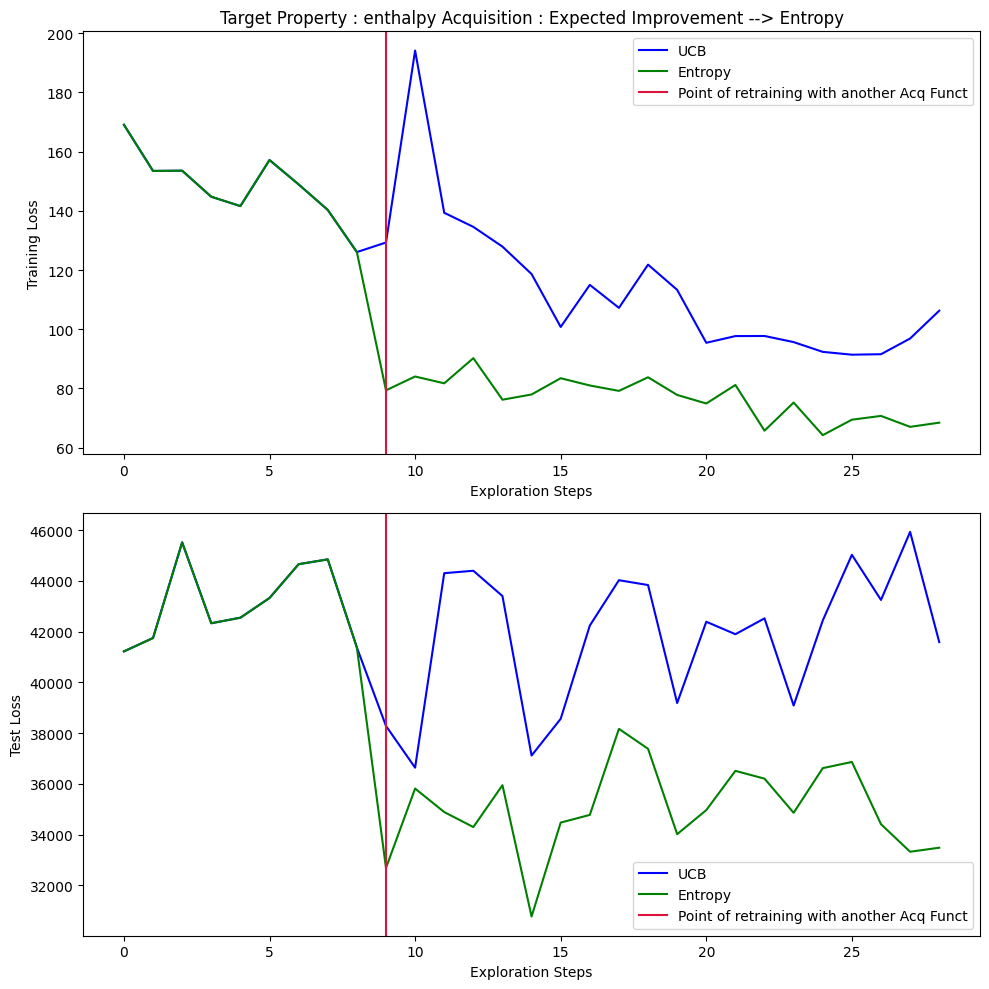

In [257]:
import matplotlib.pyplot as plt
index = executions[executions['id']==index_of_loss_increase].index[0]
print("index :",index)
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# Plot Training Loss
print(len(train_loss))
axs[0].plot(df["custom_properties_Train_Loss"],label="UCB", c='blue')
axs[0].plot(train_loss[:len(df)],label=f"{acquisition_function}",c='green') 
axs[0].axvline(x=index,c='crimson',label=f"Point of retraining with another Acq Funct")
axs[0].legend()

# Plot Test Loss
axs[1].plot(df["custom_properties_Test_Loss"],label="UCB",c='blue')
axs[1].plot(test_loss[:len(df)],label=f"{acquisition_function}",c='green')
axs[1].axvline(x=index,c='crimson',label=f"Point of retraining with another Acq Funct")
axs[1].legend()
# Plot Pearson Coefficient
# axs[2].plot(df["custom_properties_Pearson_Coeff"][:len(test_loss)],label="Entropy")
# axs[2].plot(pearson_coeff,label=f"{acquisition_function}",c='green')
# axs[2].axvline(x=len(df[:index_of_loss_increase]["custom_properties_Train_Loss"]),c='crimson',label=f"Point of retraining with another Acq Funct")
# axs[2].legend()

axs[0].set_title(f'Target Property : {target_property} Acquisition : Expected Improvement --> {acquisition_function}')
axs[0].set_xlabel('Exploration Steps')
axs[0].set_ylabel('Training Loss')

# axs[1].set_title('Test Loss')
axs[1].set_xlabel('Exploration Steps')
axs[1].set_ylabel('Test Loss')

# axs[2].set_title('Pearson Coefficient')
# axs[2].set_xlabel('Exploration Steps')
# axs[2].set_ylabel('Pearson Coefficient')


plt.tight_layout()
plt.show()


In [ ]:
_ = metalogger.log_dataset("DKL/X_al.npy","input")
_ = metalogger.log_dataset("DKL/trgt_enthalpy_al.npy","input")

_ = metalogger.log_dataset("DKL/active_train_0.npy","output")
_ = metalogger.log_dataset("DKL/active_trgt_0.npy","output")


for e in range(exp_step):
    _ = metalogger.create_execution(execution_type=f"ActiveLearningTraining_{e}_{acquisition_function}_exp", custom_properties={"Execution_Step":e,
                                                                                                      "Acquisition_function":f"{acquisition_function}",
                                                                                                         "Target_Property":f"{target_property}",
                                                                                                        "Training_loss":train_loss[e],
                                                                                                        "Test_Loss":test_loss[e]})

    _ = metalogger.log_model(f"DKL/active_learning_nn_model_{e+1}_{acquisition_function}.npy","output",model_framework="mlp",model_name='nn_params')
    _ = metalogger.log_model(f"DKL/active_learning_kernel_model_{e+1}_{acquisition_function}.npy","input",model_framework="gpax",model_name='kernel_params')
    
    _ = metalogger.log_dataset(f"DKL/active_train_{e+1}_{acquisition_function}.npy","output")
    _ = metalogger.log_dataset(f"DKL/active_trgt_{e+1}_{acquisition_function}.npy","output")
    _ = metalogger.log_dataset(f"DKL/embed_traj_{e+1}_{acquisition_function}.npy","output")

    for obj in objective_func[e]:
        metalogger.log_metric(f"DKL/obj_funct{e}_{acquisition_function}_val",{"obj_val":float(obj)})
    _ = metalogger.commit_metrics(f"DKL/obj_funct{e}_{acquisition_function}_val")

    _ = metalogger.log_model(f"DKL/active_learning_nn_model_{e}_{acquisition_function}.npy","input",model_framework="mlp",model_name='nn_params')
    _ = metalogger.log_model(f"DKL/active_learning_kernel_model_{e}_{acquisition_function}.npy","input",model_framework="gpax",model_name='kernel_params')

    if e==0:
        _ = metalogger.log_dataset(f"DKL/active_train_{e}.npy","input")
        _ = metalogger.log_dataset(f"DKL/active_trgt_{e}.npy","input")
    else:
        _ = metalogger.log_dataset(f"DKL/active_train_{e}_{acquisition_function}.npy","input")
        _ = metalogger.log_dataset(f"DKL/active_trgt_{e}_{acquisition_function}.npy","input")

_ = metalogger.log_execution_metrics("metrics", {"train_loss": train_loss, "test_loss": test_loss})

Unexpected Unable to find DVC file with output 'DKL/active_trgt_1_Entropy.npy', <class 'dvc.exceptions.OutputNotFoundError'>
Unexpected Unable to find DVC file with output 'DKL/active_trgt_1_Entropy.npy', <class 'dvc.exceptions.OutputNotFoundError'>


Entropy Acquisition Function: SMILES Molecules

Acquisition Function : UCB 

Target Property: Enthalpy

Inferred GP kernel parameters
k_length         [1.3175    1.6007999]
k_scale          6.1338
noise            1.8274


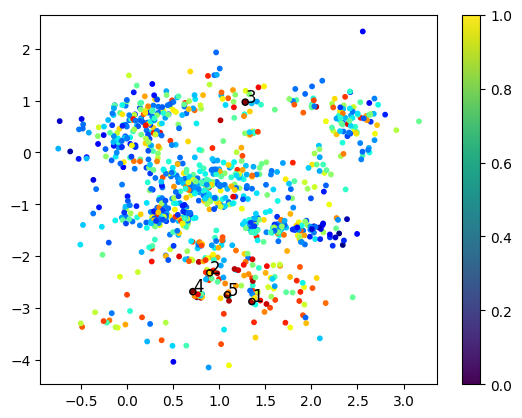

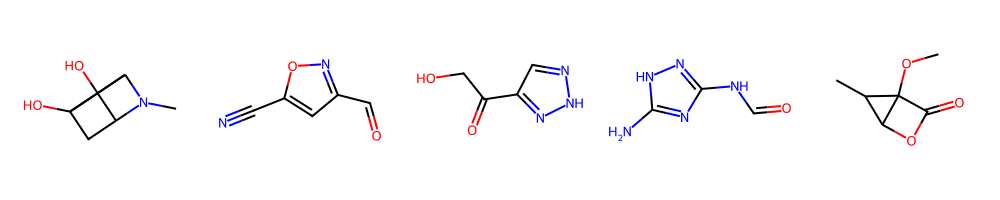

In [260]:
print("Acquisition Function : UCB \n\nTarget Property: Enthalpy")

molecules = {}
batch_size_reconstruct = 250
dkl_1.fit(rng_key_1,X1_train,y1_train)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)

embeded_1 = dkl_1.embed(X1) 
max_indices = np.argsort(targets1 - pred_mean1)[-5:]
# Plot the original scatter plot
plt.scatter(embeded_1[:, 1], embeded_1[:, 0], s=10,c=targets1 - pred_mean1, cmap='jet')
    
# Plot circles and offset numbers around the 5 maximal points
for i, idx in enumerate(max_indices):
    plt.scatter(embeded_1[idx, 1], embeded_1[idx, 0],
                s=20, facecolors='none', edgecolors='black')
    # Offset the text slightly from the circle
    plt.text(embeded_1[idx, 1], embeded_1[idx, 0],
             str(i+1), color='black', fontsize=12)

plt.colorbar()
plt.show()

# Retrieve rows from df corresponding to max_indices
maximal_rows = df_qm.iloc[max_indices]

# Extract SMILES strings in the order of max_indices
smiles_list = maximal_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects in the same order
molecules_2 = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Annotate molecules with numbers corresponding to their order
for i, mol in enumerate(molecules_2):
    if mol is not None:
        mol.SetProp("_Name", str(i+1))

molecules["UCB"] = smiles_list

# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules_2, molsPerRow=5, subImgSize=(200, 200), useSVG=True)
img

Entropy Acquisition Function: SMILES Molecules

Acquisition Function : Entropy 

Target Property: Enthalpy


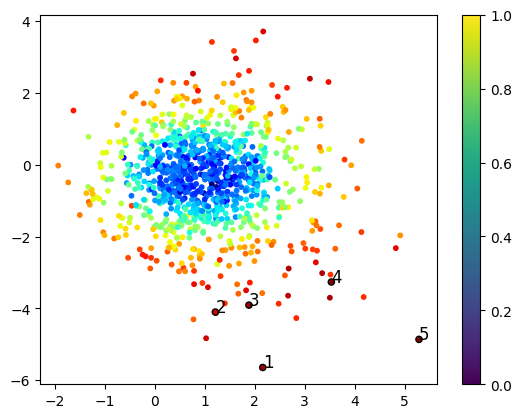

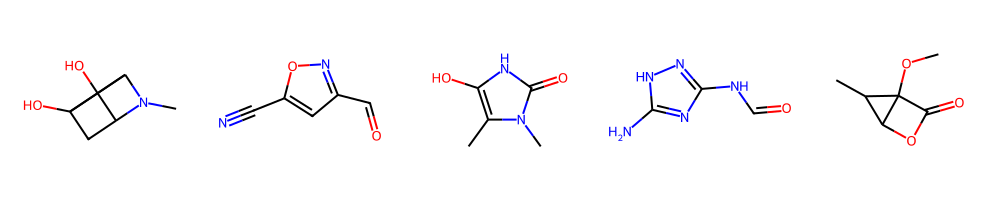

In [261]:
print("Acquisition Function : Entropy \n\nTarget Property: Enthalpy")

batch_size_reconstruct = 250
pred_mean1, pred_var1 = dkl_BO_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)

embeded_1 = dkl_BO_1.embed(X1) 
max_indices = np.argsort(targets1 - pred_mean1)[-5:]
# Plot the original scatter plot
plt.scatter(embeded_1[:, 1], embeded_1[:, 0], s=10,
            c=targets1 - pred_mean1, cmap='jet')
    
# Plot circles and offset numbers around the 5 maximal points
for i, idx in enumerate(max_indices):
    plt.scatter(embeded_1[idx, 1], embeded_1[idx, 0],
                s=20, facecolors='none', edgecolors='black')
    # Offset the text slightly from the circle
    plt.text(embeded_1[idx, 1], embeded_1[idx, 0],
             str(i+1), color='black', fontsize=12)

plt.colorbar()
plt.show()

# Retrieve rows from df corresponding to max_indices
maximal_rows = df_qm.iloc[max_indices]

# Extract SMILES strings in the order of max_indices
smiles_list = maximal_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects in the same order
molecules_2 = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Annotate molecules with numbers corresponding to their order
for i, mol in enumerate(molecules_2):
    if mol is not None:
        mol.SetProp("_Name", str(i+1))

molecules["Entropy"] = smiles_list

# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules_2, molsPerRow=5, subImgSize=(200, 200), useSVG=True)
img

Tanimoto Similarity between UCB and Entropy

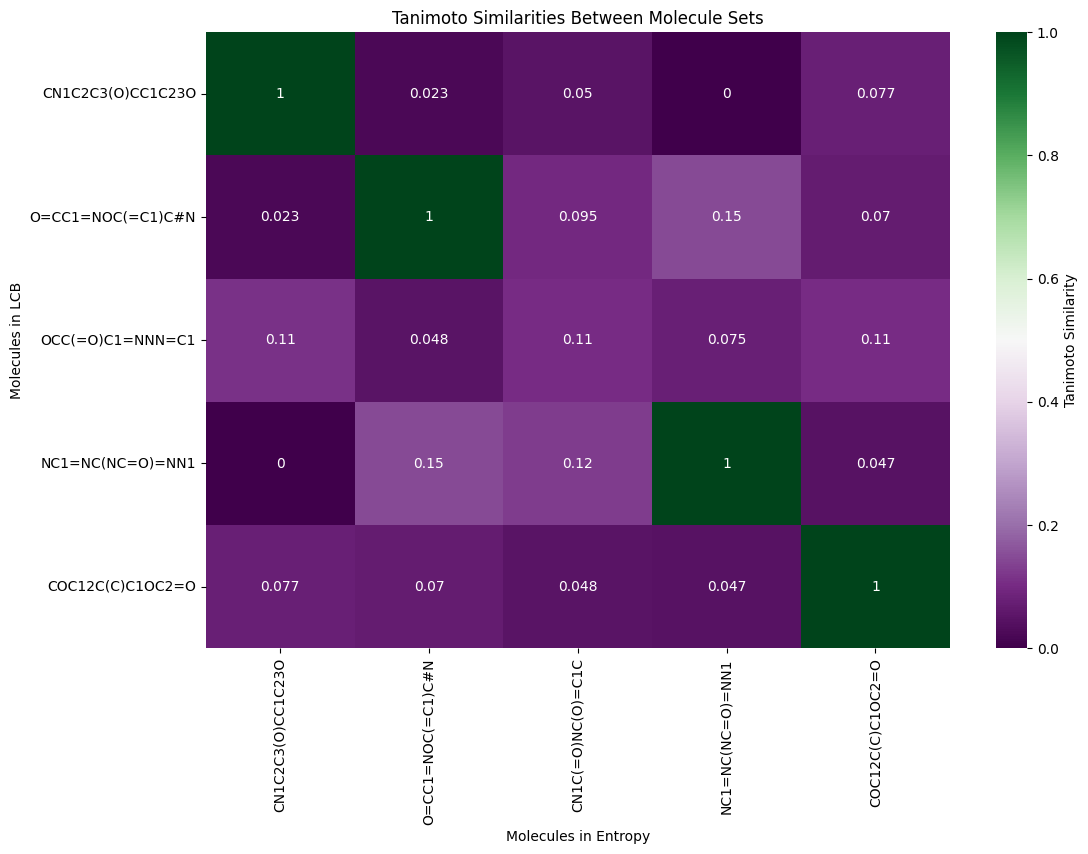

In [263]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity

# Function to calculate molecular fingerprints
def calculate_fingerprint(smiles_list):
    mol_list = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    
    # Annotate molecules with numbers corresponding to their order
    for i, mol in enumerate(mol_list):
        if mol is not None:
            mol.SetProp("_Name", str(i+1))
    
    fingerprint_list = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mol_list]
    return fingerprint_list

# Calculate fingerprints for each set
fingerprint_set1 = calculate_fingerprint(molecules["Entropy"])
fingerprint_set2 = calculate_fingerprint(molecules["UCB"])

# Calculate Tanimoto similarities
similarities = [[TanimotoSimilarity(fp1, fp2) for fp2 in fingerprint_set2] for fp1 in fingerprint_set1]

# Average Tanimoto similarity for each molecule in set1
avg_similarities_set1 = [sum(similarities[i]) / len(molecules["UCB"]) for i in range(len(molecules["Entropy"]))]

# Set up the plot
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(
    np.array(similarities),
    cmap="PRGn",
    annot=True,
    xticklabels=molecules["Entropy"],
    yticklabels=molecules["UCB"],
    cbar_kws={'label': 'Tanimoto Similarity'}
)

# Set plot labels and title
plt.xlabel('Molecules in Entropy')
plt.ylabel('Molecules in LCB')
plt.title('Tanimoto Similarities Between Molecule Sets')

# Show the plot
plt.show()
